# High level steps
1. Follow readme and have environment setup ready
2. Have model created under `util/image_extract/`
3. Search image with original this will be an exact search to find the image
4. Augment the image to simulate image caputred by different user. (image angle, shape, clour can be different. Occulusion may happen too)

In [13]:
# test search result
# exact match keep the record for later step
from util.vearchutil import ImageSearch, VearchUtil
from pprint import pprint
from PIL import Image
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from util.testutil import TestUtil

import torch
import torchvision.transforms as T

In [ ]:
# Index images with the model
# from util.load_f101 import load_data_to_vearch
# load_data_to_vearch(model_name="vgg16")

In [16]:
# add current folder in PATHONPATH
import sys
sys.path.append('./')

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# display("text/html", "<style>.container { width:100% !important; }</style>")

'text/html'

'<style>.container { width:100% !important; }</style>'

In [14]:

def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    # plt.tight_layout()

In [17]:
# batch test results
testutil = TestUtil(model_name="vgg16")
(accuracy, cmatrix,wrong_results) = testutil.test()

pprint(cmatrix)
pprint(f"Final accuracy: {accuracy}")
print("Wrong results:")
pprint(wrong_results)

INFO 2021-11-20 14:32:59,650 testutil 47470 140461325203264 TestUtil test vgg16


              blackbottles  blackcup  blacktumbler  blue  notfound  silver  \
blackbottles          21.0       0.0           0.0   0.0       0.0     0.0   
blackcup               0.0       2.0           0.0   0.0       0.0     0.0   
blacktumbler           0.0       0.0           5.0   0.0       0.0     0.0   
blue                   0.0       0.0           0.0   5.0       0.0     0.0   
notfound               0.0       0.0           0.0   0.0       0.0     0.0   
silver                 0.0       0.0           0.0   0.0       0.0     7.0   
white                  0.0       0.0           0.0   1.0       0.0     0.0   
whitecup               0.0       0.0           0.0   0.0       0.0     0.0   

              white  whitecup  
blackbottles    0.0       0.0  
blackcup        0.0       0.0  
blacktumbler    0.0       0.0  
blue            0.0       0.0  
notfound        0.0       0.0  
silver          0.0       0.0  
white           8.0       0.0  
whitecup        0.0       5.0  
'Final ac

{'data': {'image_name': './data/zerobox/images/blue/000012.png',
          'keyword': '',
          'model_name': 'vgg16',
          'sid': 'blue',
          'tags': ['blue'],
          'uuid': '701912e0-545d-4f9f-a5ec-291a7faba0e2'},
 'score': 0.9351422786712646,
 'vearch_id': '701912e0-545d-4f9f-a5ec-291a7faba0e2'}


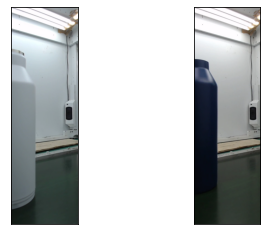

In [12]:
util = VearchUtil(model_name="vgg16")
image_name="./data/zerobox/images/white/000044.png"
item = util.search_by_image(image=image_name)
pprint(item)

image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image2 = cv2.imread(item["data"]["image_name"])
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

plot([image,image2])



In [ ]:
# todo augment the image to simulate in real world image


In [ ]:
# orig_img = cv2.imread(image_name)
# orig_img = cv2.cvtColor(orig_img,cv2.COLOR_BGR2RGB)
# plt.imshow(orig_img)
orig_img = Image.open(image_name)

pprint(type(orig_img))

In [ ]:
# update colors
jitter = T.ColorJitter(brightness=.5, hue=.3)
jitted_imgs = [jitter(orig_img) for _ in range(4)]
plot(jitted_imgs)

In [ ]:
blurrer = T.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 5))
blurred_imgs = [blurrer(orig_img) for _ in range(4)]
plot(blurred_imgs)

In [ ]:
# test transform on https://albumentations-demo.herokuapp.com/
import albumentations as A
import cv2

# Declare an augmentation pipeline
transform = A.Compose([
    # A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ISONoise(color_shift=[0.01,0.13],intensity=[0.10,1.13]),
    A.MotionBlur(blur_limit=[4,10]),
    A.OpticalDistortion(distort_limit=[-0.4,0.2],shift_limit=[-0.15,0.08],interpolation=4,border_mode=1),
    # A.RandomGamma(),
    # A.RandomRain(slant_lower=-9,slant_upper=6,drop_length=3,drop_width=1,blur_value=1,drop_color=(255,0,0))
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

item = util.search_by_image(keyword=restaurant,image=image)
t_item = util.search_by_image(keyword=restaurant,image=transformed_image)

f_image = cv2.imread(t_item["data"]["image_name"])
f_image = cv2.cvtColor(f_image, cv2.COLOR_BGR2RGB)

plot([transformed_image,f_image])

pprint(item)
pprint(t_item)
